### Change Log for Naive Bayes Classification

This notebook contains code from [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas. 

The original notebook preformed text classification training the model on a series of emails that are catagorised.
In my version, I perform text classification similar to VanderPlas but the model is trained  on a dataset of BBC news articles. 

#### [1. Understanding the Algorithm](#algorithm-understanding)
- **Objective:**
  - Get an understanding of the Naive Bayes algorithm, how the model works and decides where the decision boundry is. 
  - By creating data and visualising it, we can plot how the algoritihm percives the decion boundry. 
- **Changes:**
  1. Used `make_gaussian_quantiles` instead of `make_blobs`.
  <p float="left">
  <img src="figures/gaussianNaiveOrg.png" width="200" />
  <img src="figures/gaussiamBayesMod.png" width="200" />
  </p>
  2. Fitting the model stays the same, Then I generated some new data. <br>
  3. Plot the new data to see where the decision boundary is:
  <p float="left">
    <img src="figures/Fig3.png" width="200" />
    <img src="figures/Fig4.png" width="200" />
  </p>
  4. Output: For the first six samples, the model is quite confident that they belong to the positive class.
  For the seventh sample, the model is less confident. For the eighth sample, the model is again confident.
  

#### [2. Data Understanding](#data-understanding)
- **Dataset Description:**
  - VanderPlas used a collection from sklearn called 20 Newsgroups. 
    -The data set contains around 18,000 newsgroup documents from 20 different newsgroups.
    
  **Changes:**
  - In my model, I use the `BBC News Archive` dataset.
    - The dataset comprises 2225 documents from the BBC news from 2004-2005.
    - Five catageories: Business, Entertainment, Politics, Sport, Tech
    - The data is  a single CSV file
    - The dataset is structured with columns for 'content' (news artical) and 'category' (category of the artical).


#### [3. Data Preperation](#3-data-preparation)
- **Data Cleaning:**
  - VanderPlas does not preform any cleaning to his data
  **Changes:**
  - For my model, I preformed initial data cleaning steps:
    1. The datsaset was checked for duplicates 
    2. The dataset was checked for any nulls. 
    - The dataset was clean, there were no duplicages or null vlaues to be removed. 


#### [4. Modeling](#modeling)
- **Implementation Details:**
  - Utilized the `TfidfVectorizer` to convert the text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency)
  - Created a pipeline (`make_pipeline`) that combines the TF-IDF vectorizer with the Multinomial Naive Bayes classifier.

#### [5. Evaluation](#evaluation)
- **Performance Metrics:**
  - The evaluation metric used is accuracy, calculated using the `accuracy_score` from `sklearn.metrics`.
- **Challenges Encountered:**

#### [6. Deployment](#deployment)



In [45]:
# Standard imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#### 1. Understanding the Algorithm <a id='algorithm-understanding'></a>

##### Gaussian Naive Bayes

Perhaps the easiest Naive Bayes Classifier to understand is Gaussian Naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

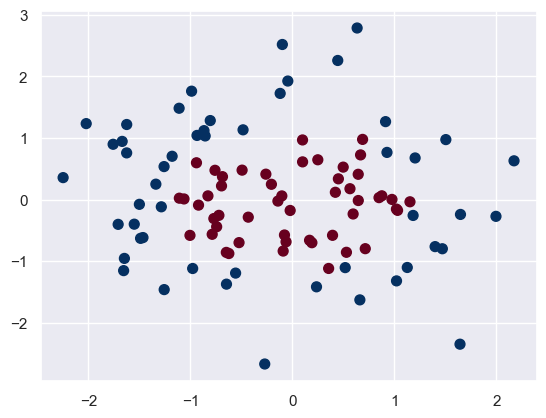

In [46]:
X, y = make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, random_state=145)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

Using Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:
- We can compute the likelihood $P({\rm features}~|~L_1)$ for any data point, 
- Thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

In [47]:
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [48]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

(-2.4697105006580076,
 2.3936695096993454,
 -2.9447766101024175,
 3.0609494941252087)

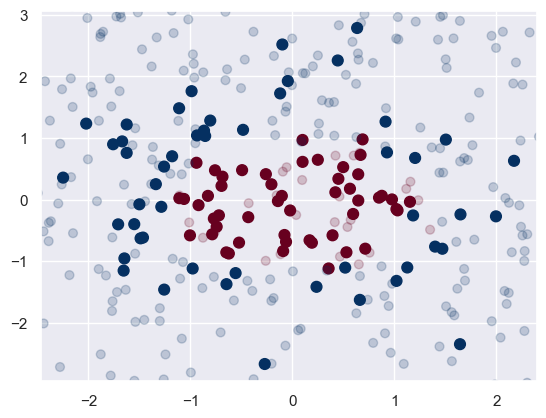

In [49]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=40, cmap='RdBu', alpha=0.2)
plt.axis(lim)

In [50]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.45, 0.55],
       [0.  , 1.  ]])

# In Depth: Naive Bayes Classification

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where Multinomial Naive Bayes is often used is in text classification.
- Features are related to the word counts or frequencies within the documents to be classified.

-  In this example, I will use the sparse word count features from 2225 documents from the BBC news from 2004-2005 to show how we classify these articals into categories. 

- Using this we can then make a prediction of a sentence to see what news catageory it belogs in. 

We begin by importing our CSV file: 

In [51]:
newsDataRaw = pd.read_csv('bbc-news-data.csv', delimiter='\t')
newsDataRaw.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


#### 2. Data Understanding <a id='data-understanding'></a>
**Dataset Description:** 
The data set is taken from `BBC News Archive` dataset.
- The dataset comprises 2225 documents from the BBC news from 2004-2005.
    - Five catageories: Business, Entertainment, Politics, Sport, Tech
    - The data is  a single CSV file
    - The dataset is structured with columns for category, file name, title & content. 

CSV Files:
 -  bbc-news-data.csv

In [67]:
print("Dataset Shape:", newsDataRaw.shape)

Dataset Shape: (2225, 4)


#### 3. Data Preparation <a id='data-preparation'></a>

In [52]:
# Remove duplicates 
duplicated_rows = newsDataRaw[newsDataRaw.duplicated()]
print(f"Number of duplicated rows: {len(duplicated_rows)}")

Number of duplicated rows: 0


In [53]:
#nulls  = newsDataRaw.isnull().sum()
#print("Nulls in the dataset:\n", nulls_or_blanks)

#### 4. Modeling <a id='modeling'></a>

We split our data into a test a train split
- Our model will use a 80% train and 20% test split 

In [54]:
categories = ['business' 'entertainment' 'politics' 'sport' 'tech']

train, test = train_test_split(
    newsDataRaw[['content', 'category']],
    test_size=0.2,
    random_state=42
)

# Print the sizes of the training and testing sets
print("Training set size:", len(train))
print("Testing set size:", len(test))

Training set size: 1780
Testing set size: 445


Here is a representative entry from the data:

In [55]:
print(train)

                                                content       category
1490   Ashley Cole has refused to blame Robin van Pe...          sport
2001   Sony PlayStation 2's slimmer shape has proved...           tech
1572   Newcastle have fined their Welsh striker Crai...          sport
1840   Re-using old mobile phones is not just good f...           tech
610    International films will be given the same pr...  entertainment
...                                                 ...            ...
1638   England captain Jason Robinson has rubbished ...          sport
1095   Middlesbrough mayor Ray Mallon has been draft...       politics
1130   The Lib Dems have appointed a senior figure f...       politics
1294   Sacked MP Howard Flight's local Conservative ...       politics
860    Women in the UK film industry earn less than ...  entertainment

[1780 rows x 2 columns]


In [56]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [57]:
model.fit(train['content'], train['category'])
labels = model.predict(test['content'])

#### 5. Evaluation <a id='evaluation'></a>

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

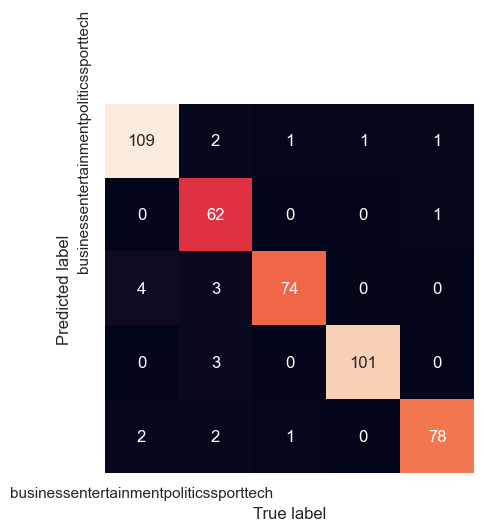

In [58]:
mat = confusion_matrix(test['category'], labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [59]:
def predict_category(input, model=model):
    pred = model.predict([input])
    return pred[0]


Let's try it out:

In [60]:
predict_category("when the market closed the stock then")

'business'

In [61]:
predict_category("has won her 1st Grammy")

'entertainment'

In [62]:
predict_category("In his second time running for election he ")

'politics'

In [63]:
predict_category("Have launched their new earphones")

'tech'

In [64]:

true_labels = test['category']

accuracy = accuracy_score(true_labels, labels)

print(f'Accuracy: {accuracy}')


Accuracy: 0.952808988764045


#### 6. Deployment <a id='deployment'></a>